In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_27755/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

### SHERBROOKE DETAILS ###
backend = provider.get_backend('ibm_sherbrooke') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 1

In [3]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7f86dc099fa0>
backend_name
ibm_sherbrooke
backend_version
1.4.47
n_qubits
127
basis_gates
['id', 'rz', 'sx', 'x', 'ecr', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112

## Acquisition Scan with varying duration Ring-Up Tone

In [17]:
from utils import get_dt_from, convert_arr_to_dt

acq_latency_dt = get_dt_from(750 * ns, dt)
acq_dur_dt = get_dt_from(16. * ns, dt)
kappa = 14.31 # From AC Stark-Shift based Photon Measurement
mu = 1/measure_pulse.amp
rough_tau_1_us = 2 / kappa * np.log(mu / (mu - 1))

tau_1_vals = np.array([
    rough_tau_1_us - 0.010,
    rough_tau_1_us,
    rough_tau_1_us + 0.010,
    rough_tau_1_us + 0.020,
    rough_tau_1_us + 0.030,
    rough_tau_1_us + 0.040,
]) * us

tau_1_vals = convert_arr_to_dt(tau_1_vals, dt)

print(f"Rough Tau 1: {rough_tau_1_us * 1000.}ns")
print(f"Tau 1 vals: {tau_1_vals / ns}ns")

Rough Tau 1: 59.77787799517598ns
Tau 1 vals: [49.77777778 60.44444444 71.11111111 78.22222222 88.88888889 99.55555556]ns


[  0.          17.77777778  35.55555556  49.77777778  67.55555556
  85.33333333 103.11111111 120.88888889 135.11111111 152.88888889
 170.66666667 188.44444444 202.66666667 220.44444444 238.22222222
 256.         273.77777778 288.         305.77777778 323.55555556
 341.33333333 359.11111111 373.33333333 391.11111111 408.88888889
 426.66666667 440.88888889 458.66666667 476.44444444 494.22222222
 512.         526.22222222 544.         561.77777778 579.55555556
 597.33333333 611.55555556 629.33333333 647.11111111 664.88888889
 679.11111111 696.88888889 714.66666667 732.44444444 750.22222222
 764.44444444 782.22222222 800.        ]


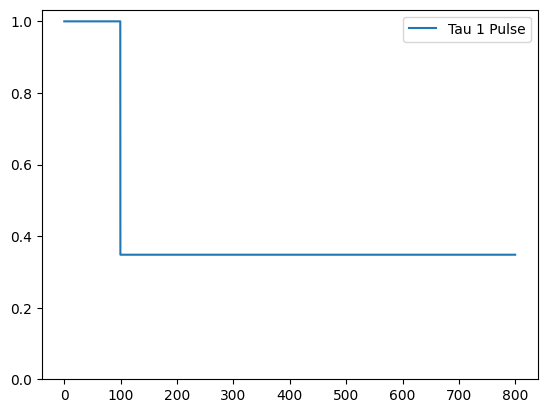

In [18]:
acq_start_dt = get_dt_from(0. * ns, dt)
acq_end_dt = get_dt_from(800. * ns, dt)
meas_pulse_dur_dt = (acq_end_dt - acq_start_dt)
num_acq_exp = 48
acq_delay_linspace = np.linspace(acq_start_dt, acq_end_dt, num_acq_exp) * dt
acq_delay_linspace_us = convert_arr_to_dt(acq_delay_linspace)

print(acq_delay_linspace_us/ns)

def get_tau_1_waveform(tau_1_dur_dt, total_dur_dt):
    t1_times = np.arange(total_dur_dt) * dt
    tau_1_pulse = measure_pulse.amp * np.heaviside(t1_times - tau_1_dur_dt * dt, 1.)
    tau_1_pulse += np.heaviside(tau_1_dur_dt * dt - t1_times, 0.)
    return tau_1_pulse

tau_1_pulse = get_tau_1_waveform(get_dt_from(tau_1_vals[-1], dt), meas_pulse_dur_dt)

t_plot = np.arange(len(tau_1_pulse)) * dt / ns
plt.plot(t_plot, tau_1_pulse, label='Tau 1 Pulse')
plt.ylim(bottom=0.)
plt.legend()
plt.show()

288
288


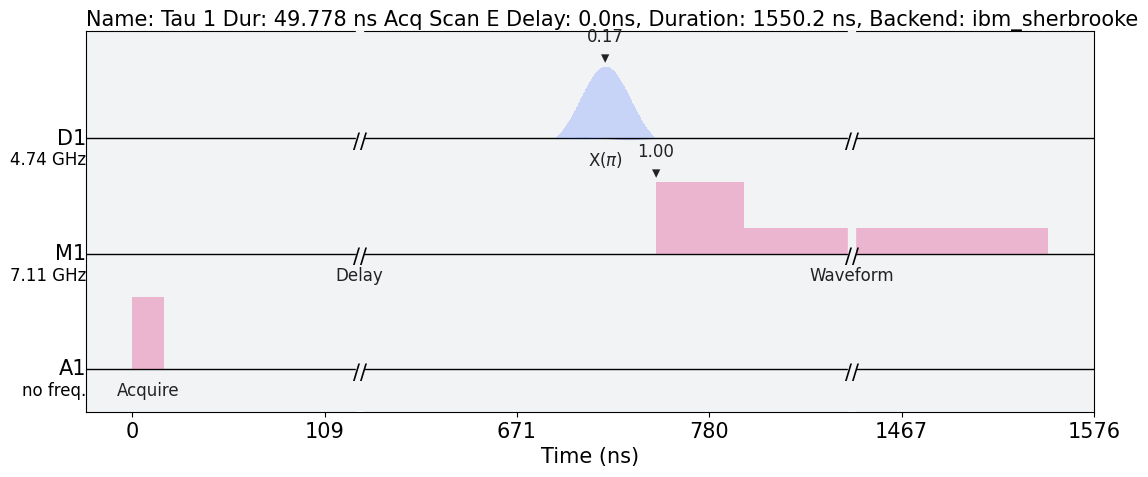

In [20]:
# Making Experiments

tau_1_exps_g = []
tau_1_exps_e = []

for tau_1_us in tau_1_vals:
    tau_1_pulse = get_tau_1_waveform(get_dt_from(tau_1_us, dt), meas_pulse_dur_dt)
    tau_1_ns = np.round(tau_1_us/ns, 3)

    for acq_delay_us in acq_delay_linspace_us:
        acq_delay_dt = get_dt_from(acq_delay_us, dt)
        acq_delay_ns = np.round(acq_delay_us/ns, 3)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Tau 1 {tau_1_ns} ns Acq Scan G Delay: {acq_delay_ns}ns',
        ) as tau_1_sched_g:
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(tau_1_pulse, meas_chan)
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                acq_dur_dt,
                qubit,
                pulse.MemorySlot(qubit),
            )
        tau_1_exps_g.append(tau_1_sched_g)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Tau 1 Dur: {tau_1_ns} ns Acq Scan E Delay: {acq_delay_ns}ns',
        ) as tau_1_sched_e:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            with pulse.align_right():
                pulse.play(x_pulse, qubit_chan)
                pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(tau_1_pulse, meas_chan)
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                acq_dur_dt,
                qubit,
                pulse.MemorySlot(qubit),
            )
        tau_1_exps_e.append(tau_1_sched_e)

print(len(tau_1_exps_g))
print(len(tau_1_exps_e))

tau_1_exps_e[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

288
288


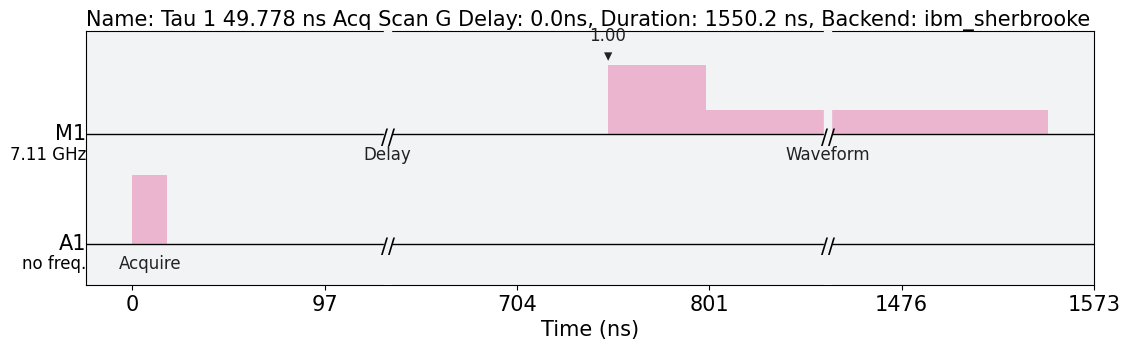

In [24]:
from utils import acquisition_checker

jobs_g = np.array(tau_1_exps_g).reshape(2, -1).tolist()
jobs_e = np.array(tau_1_exps_e).reshape(2, -1).tolist()

batch_1 = jobs_g[0] + jobs_e[0]
batch_2 = jobs_g[1] + jobs_e[1]

acquisition_checker(batch_1, backend)
acquisition_checker(batch_2, backend)
print(len(batch_1))
print(len(batch_2))

num_shots = 8192
rep_delay = 499.0 * us

batch_1[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [26]:
# Running total_job

job_experiment = backend.run(batch_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued (None)

KeyboardInterrupt: 

In [ ]:
job_1 = provider.backend.retrieve_job(job_id='cs2jp91kfpw00080g8bg') # Queue
job_2 = provider.backend.retrieve_job(job_id='cs2jpgayhpyg008am9rg') # Queue

In [ ]:
from utils import get_results_arr

results_1 = get_results_arr(job_1.result(), qubit)
results_2 = get_results_arr(job_2.result(), qubit)

In [ ]:
batch_1_g, batch_1_e = results_1.reshape(2, -1, num_shots)
batch_2_g, batch_2_e = results_2.reshape(2, -1, num_shots)

batch_g = np.concatenate((batch_1_g, batch_2_g), axis=0)
batch_e = np.concatenate((batch_1_e, batch_2_e), axis=0)

print(batch_g.shape)
print(batch_e.shape)

## Tau 1 Acquisition Scan Results

In [ ]:
from utils import get_fidelity

acq_fidelity, sep_acq_fidelity = get_fidelity(batch_g, batch_e)

acq_fidelity = acq_fidelity.reshape(len(tau_1_vals), -1)
sep_acq_fidelity = sep_acq_fidelity.reshape(len(tau_1_vals), -1)

acq_pf = -np.log10(1. - acq_fidelity)
sep_acq_pf = -np.log10(1. - sep_acq_fidelity)

In [ ]:
ts = acq_delay_linspace_us/ns

fig, ax = plt.subplots(2, figsize=(8.0, 10.0))

for i, (acq_pf_obj, sep_pf_obj, tau_1_obj) in enumerate(zip(acq_pf, sep_acq_pf, tau_1_vals)):
    print(np.max(acq_pf_obj))
    print(ts[np.argmax(acq_pf_obj)])

    ax[0].plot(ts, acq_pf_obj, label=f'fid w tau_1: {tau_1_obj/ns}ns')
    ax[1].plot(ts, sep_pf_obj, label=f'sep fid w tau_1: {tau_1_obj/ns}ns')
ax[0].axhline(y=0.3, linestyle='dashed', color='grey')
ax[1].axhline(y=0.3, linestyle='dashed', color='grey')
ax[0].legend()
ax[1].legend()
plt.show()